# Heatmaps MT vs T2I
Dieses Notebook lädt MT- und CLIP-Modelle, berechnet Attention-Matrizen für einen gegebenen Text und visualisiert sie als Heatmaps.

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install transformers seaborn matplotlib
!pip install sentencepiece
!pip install sentencepiece sacremoses
!pip install matplotlib
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install diffusers transformers accelerate safetensors torch
!pip install pillow

Looking in indexes: https://download.pytorch.org/whl/cpu
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ----------- ---------------------------- 3.7/12.8 MB 23.9 MB/s eta 0:00:01
     ------------------------------- ------- 10.2/12.8 MB 29.9 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 25.2 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, CLIPTokenizer, CLIPTextModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
plt.rcParams["font.family"] = ["DejaVu Sans"]
sns.set(style="whitegrid")
import transformers
transformers.logging.set_verbosity_error()

In [30]:
import torch
from transformers import MarianTokenizer, MarianModel

MT_MODEL_NAME = "Helsinki-NLP/opus-mt-en-de"

mt_tokenizer = MarianTokenizer.from_pretrained(MT_MODEL_NAME)

mt_base_model = MarianModel.from_pretrained(MT_MODEL_NAME, output_attentions=True)
mt_base_model.eval()

mt_encoder = mt_base_model.encoder

print("Tokenizer:", type(mt_tokenizer))
print("Base model:", type(mt_base_model))
print("Encoder:", type(mt_encoder))
assert "MarianEncoder" in str(type(mt_encoder)), "mt_encoder ist nicht der Encoder!"

def mt_embed(text: str):
    inputs = mt_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = mt_encoder(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            return_dict=True,
        )
    mask = inputs["attention_mask"].unsqueeze(-1)          # [1, seq_len, 1]
    hidden = outputs.last_hidden_state                     # [1, seq_len, hidden]
    summed = (hidden * mask).sum(dim=1)                    # [1, hidden]
    lengths = mask.sum(dim=1).clamp(min=1)                 # [1, 1]
    return summed / lengths                                # [1, hidden]

mt_tok = mt_tokenizer
mt_enc = mt_encoder

Tokenizer: <class 'transformers.models.marian.tokenization_marian.MarianTokenizer'>
Base model: <class 'transformers.models.marian.modeling_marian.MarianModel'>
Encoder: <class 'transformers.models.marian.modeling_marian.MarianEncoder'>


In [8]:
clip_model_name = "openai/clip-vit-base-patch32"
clip_tok = CLIPTokenizer.from_pretrained(clip_model_name)
clip_enc = CLIPTextModel.from_pretrained(clip_model_name, output_attentions=True)

Warum Clip? (https://huggingface.co/openai/clip-vit-base-patch32)
1. Multimodales Training	CLIP wurde auf Text–Bild-Paaren trainiert (z. B. „A red ball“ ↔ Bild eines roten Balls). Dadurch ist seine Textrepräsentation stark semantisch und weniger syntaktisch geprägt.
2. Semantische Robustheit	CLIP versteht, dass „A dog running in the park“ ≈ „A running dog in a park“ fast die gleiche Bedeutung hat. Perfekt für Satzumstellungs-Experimente.
3. Zugriff auf Attention-Maps	Das Modell erlaubt den Zugriff auf attentions, was es ermöglicht, interne Strukturunterschiede visuell zu vergleichen.
4. Vergleich zu MT-Modellen	Machine Translation (MT) Modelle wie MarianMT sind stärker syntaktisch gebunden — der Kontrast zeigt also genau den Unterschied zwischen „formbasiert“ und „bedeutungsbasiert“.

Warum Helsinki-NLP? (https://huggingface.co/Helsinki-NLP/opus-mt-en-de)

1. Sprachmodelltyp	MarianMT wurde für maschinelle Übersetzung trainiert, nicht für semantisches Matching. Es fokussiert sich stark auf Wortreihenfolge, Grammatik und Syntax.
2. Syntaktische Sensitivität	Schon kleine Umstellungen (z. B. „On the table is a ball“ vs. „A ball is on the table“) verändern die internen Repräsentationen stärker — das zeigt, wie sequenzsensitiv das Modell ist.
3. Zugriff auf Attention-Matrizen	Wie CLIP erlaubt auch MarianMT den Zugriff auf output_attentions=True, was die Visualisierungen von Satzstruktur und Wortabhängigkeiten ermöglicht.
4. Multilinguale Datenbasis	Trainiert auf OPUS-Daten, also parallelen Textkorpora in über 40 Sprachen → robust und wissenschaftlich gut dokumentiert.

In [10]:
text = "A red ball on the wooden table"
mt_inp = mt_tokenizer(text, return_tensors="pt")  
clip_inp = clip_tok(text, return_tensors="pt")    

In [13]:
import torch

mt_enc = mt_encoder       
mt_tok = mt_tokenizer     

text = "A red ball on the wooden table"
mt_inp = mt_tok(text, return_tensors="pt")
clip_inp = clip_tok(text, return_tensors="pt")

with torch.no_grad():
    mt_out = mt_enc(
        input_ids=mt_inp["input_ids"],
        attention_mask=mt_inp["attention_mask"],
        output_attentions=True,
        return_dict=True,
    )
    clip_out = clip_enc(
        input_ids=clip_inp["input_ids"],
        attention_mask=clip_inp["attention_mask"],
        output_attentions=True,
        return_dict=True,
    )

mt_att = mt_out.attentions
clip_att = clip_out.attentions

print(f"MT layers: {len(mt_att)}, CLIP layers: {len(clip_att)}")

MT layers: 6, CLIP layers: 12


In [14]:
mt_last = mt_att[-1][0]
mt_mean = mt_last.mean(0)

clip_last = clip_att[-1][0]
clip_mean = clip_last.mean(0)

In [15]:
mt_tokens = mt_tok.convert_ids_to_tokens(mt_inp['input_ids'][0])
clip_tokens = clip_tok.convert_ids_to_tokens(clip_inp['input_ids'][0])
mt_tokens = mt_tokens[:mt_mean.shape[0]]
clip_tokens = clip_tokens[:clip_mean.shape[0]]

X:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


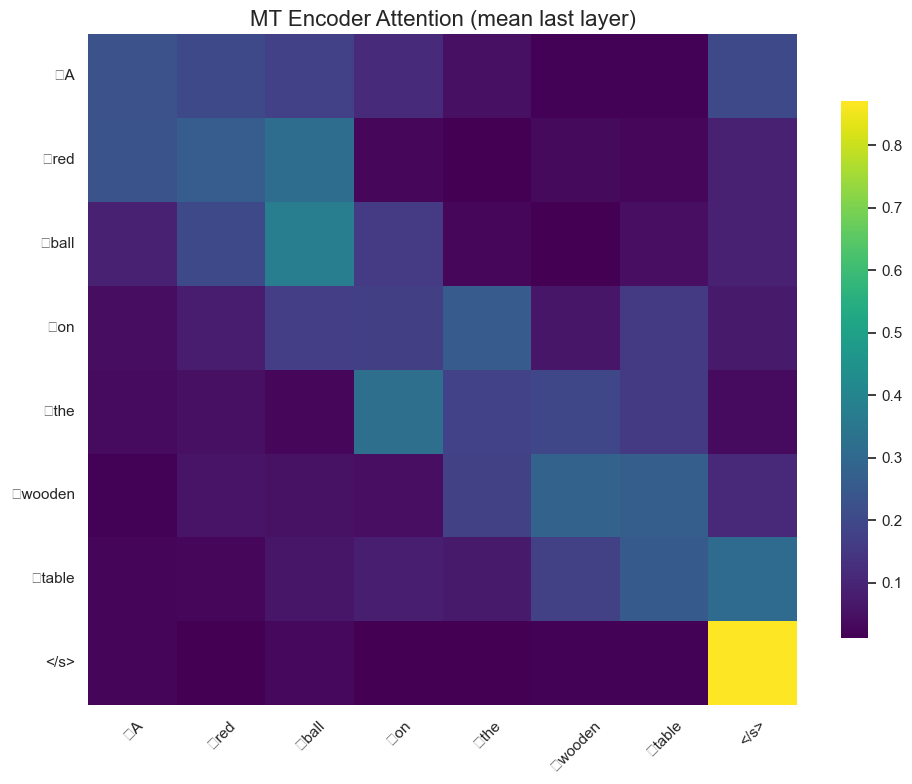

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(mt_mean.cpu().numpy(), xticklabels=mt_tokens, yticklabels=mt_tokens, cmap="viridis", cbar_kws={"shrink": 0.8})
plt.title("MT Encoder Attention (mean last layer)", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

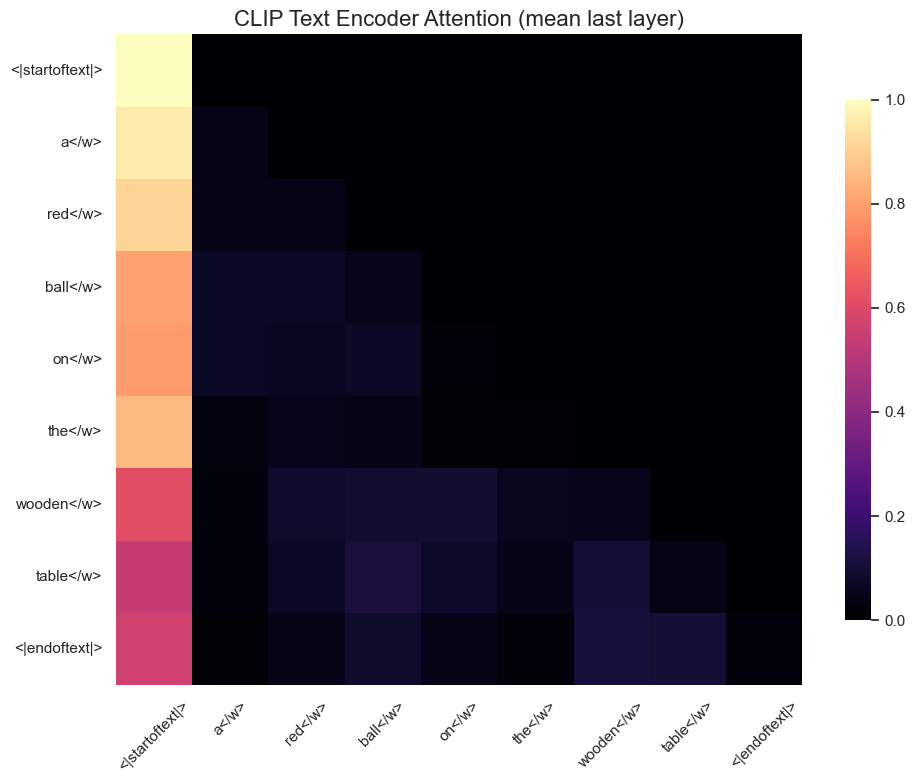

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(clip_mean.cpu().numpy(), xticklabels=clip_tokens, yticklabels=clip_tokens, cmap="magma", cbar_kws={"shrink": 0.8})
plt.title("CLIP Text Encoder Attention (mean last layer)", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Satzumstellung

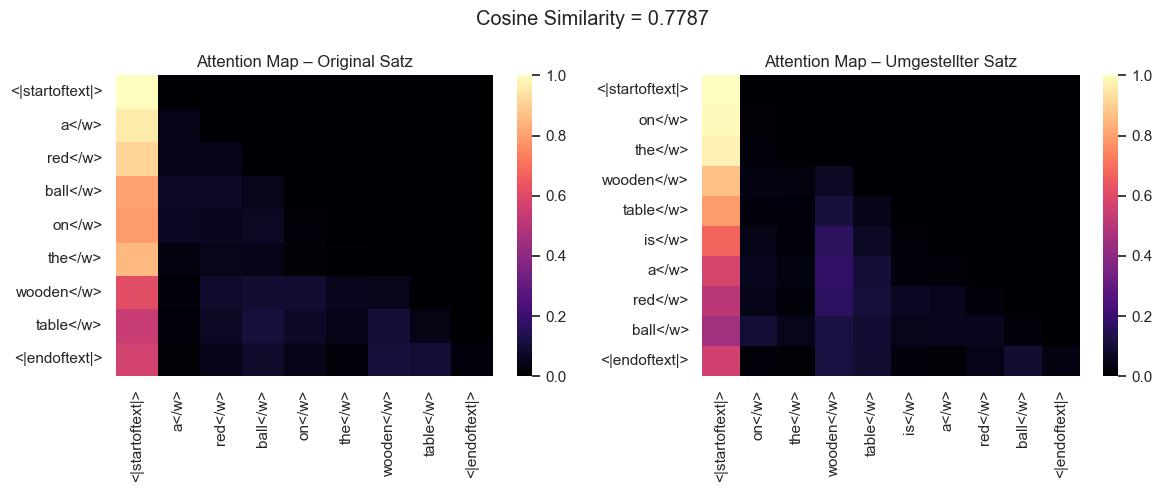

In [18]:
# --- Libraries ---
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import CLIPTokenizer, CLIPTextModel
from sklearn.metrics.pairwise import cosine_similarity

model_name = "openai/clip-vit-base-patch32"
tok = CLIPTokenizer.from_pretrained(model_name)
enc = CLIPTextModel.from_pretrained(model_name, output_attentions=True)

text1 = "A red ball on the wooden table"
text2 = "On the wooden table is a red ball"

inp1 = tok(text1, return_tensors="pt")
inp2 = tok(text2, return_tensors="pt")

with torch.no_grad():
    out1 = enc(**inp1)
    out2 = enc(**inp2)

e1 = out1.last_hidden_state.mean(1)
e2 = out2.last_hidden_state.mean(1)
sim = cosine_similarity(e1, e2)[0][0]

att1 = out1.attentions[-1][0].mean(0).cpu().numpy()  # (seq_len, seq_len)
att2 = out2.attentions[-1][0].mean(0).cpu().numpy()

tokens1 = tok.convert_ids_to_tokens(inp1["input_ids"][0])
tokens2 = tok.convert_ids_to_tokens(inp2["input_ids"][0])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(att1, xticklabels=tokens1, yticklabels=tokens1, cmap="magma", ax=axes[0])
axes[0].set_title("Attention Map – Original Satz")

sns.heatmap(att2, xticklabels=tokens2, yticklabels=tokens2, cmap="magma", ax=axes[1])
axes[1].set_title("Attention Map – Umgestellter Satz")

plt.suptitle(f"Cosine Similarity = {sim:.4f}")
plt.tight_layout()
plt.show()


Cosine Similarity misst, wie ähnlich sich zwei Satzrepräsentationen im Bedeutungsraum sind —
sie ist 1, wenn die Sätze fast die gleiche Bedeutung haben, und 0 (oder negativ), wenn sie völlig verschieden sind.

Je näher der Wert an 1 liegt, desto ähnlicher ist die Bedeutung laut Modell.

# Chunking

Detected chunks: ['A red ball', 'the wooden table']


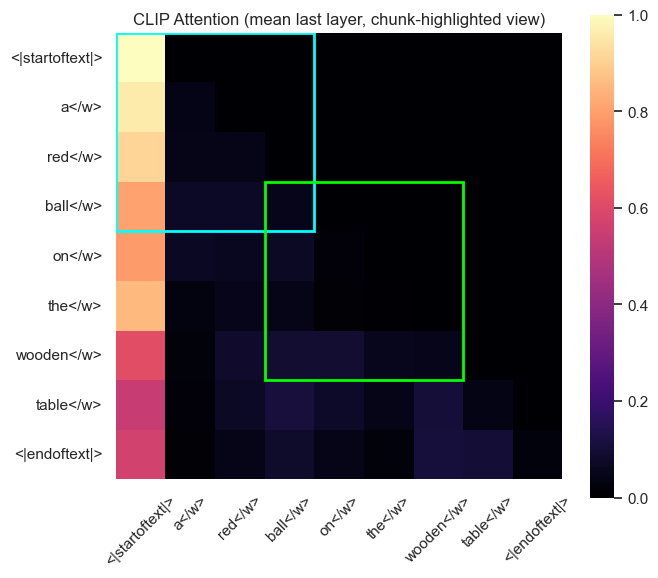

In [19]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import CLIPTokenizer, CLIPTextModel
import spacy
import numpy as np
import matplotlib.patches as patches

clip_tok = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_enc = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32", output_attentions=True)
nlp = spacy.load("en_core_web_sm")

text = "A red ball on the wooden table"
doc = nlp(text)
chunks = [chunk.text for chunk in doc.noun_chunks]
print("Detected chunks:", chunks)

inputs = clip_tok(text, return_tensors="pt")
outputs = clip_enc(**inputs)
att = outputs.attentions[-1][0]  # letzte Layer-Attention
att_mean = att.mean(0).detach().cpu().numpy()
tokens = clip_tok.convert_ids_to_tokens(inputs["input_ids"][0])

plt.figure(figsize=(7, 6))
sns.heatmap(att_mean, xticklabels=tokens, yticklabels=tokens, cmap="magma", square=True)
plt.title("CLIP Attention (mean last layer, chunk-highlighted view)")
plt.xticks(rotation=45)

token_texts = [t.replace("</w>", "") for t in tokens]
chunk_positions = []

for chunk in doc.noun_chunks:
    start, end = chunk.start, chunk.end
    chunk_tokens = clip_tok(chunk.text, return_tensors="pt")["input_ids"][0]
    # Suche nach Startposition im CLIP-Token-Array
    for i in range(len(token_texts)):
        joined = " ".join(token_texts[i:i+len(chunk_tokens)])
        if chunk.root.text.lower() in joined.lower():
            chunk_positions.append((i, i+len(chunk_tokens)-1))
            break

ax = plt.gca()
colors = ["cyan", "lime", "orange", "deepskyblue"]
for i, (start, end) in enumerate(chunk_positions):
    rect = patches.Rectangle(
        (start, start),
        end - start,
        end - start,
        linewidth=2,
        edgecolor=colors[i % len(colors)],
        facecolor='none'
    )
    ax.add_patch(rect)

plt.tight_layout()
plt.savefig("clip_attention_chunks_highlighted.png", dpi=300)
plt.show()


In der Attention-Darstellung von CLIP lassen sich syntaktische Chunks wie „A red ball“ und „the wooden table“ deutlich voneinander abgrenzen.
Dies deutet darauf hin, dass das Modell semantische Kohärenz innerhalb von Phrasen stärker gewichtet, während verbindende Präpositionen wie „on“ weniger fokussiert werden.
Solche Muster sind relevant für Text-zu-Bild-Modelle, da sie zeigen, dass die Repräsentation visueller Szenen auf inhaltlich konsistente Textsegmente aufbaut.

Detected chunks: ['A red ball', 'the wooden table']


C:\Users\User\AppData\Local\Temp\ipykernel_3636\571299203.py:57: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Arial.
  plt.savefig("mt_attention_chunks_highlighted.png", dpi=300)
X:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


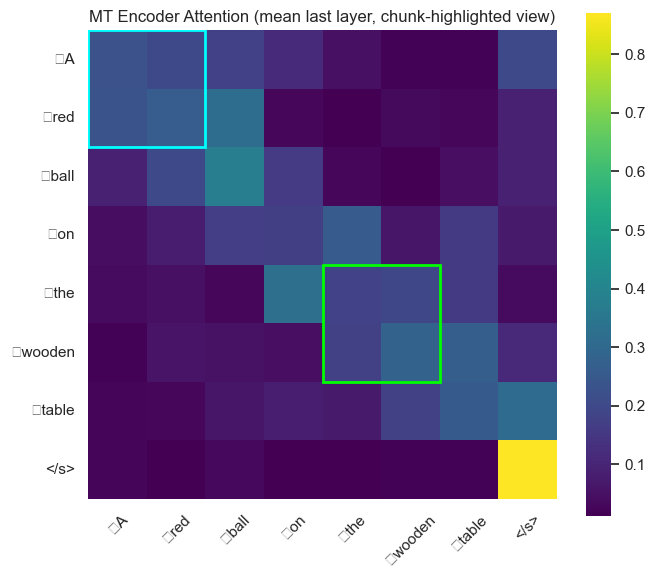

In [20]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import MarianTokenizer, MarianMTModel
import spacy
import matplotlib.patches as patches

mt_model_name = "Helsinki-NLP/opus-mt-en-de"
mt_tok = MarianTokenizer.from_pretrained(mt_model_name)
mt_enc = MarianMTModel.from_pretrained(mt_model_name, output_attentions=True)
nlp = spacy.load("en_core_web_sm")

text = "A red ball on the wooden table"
doc = nlp(text)
chunks = [chunk.text for chunk in doc.noun_chunks]
print("Detected chunks:", chunks)

inp = mt_tok(text, return_tensors="pt")
out = mt_enc.model.encoder(**inp, output_attentions=True)
att = out.attentions[-1][0].mean(0).detach().cpu().numpy()
tokens = mt_tok.convert_ids_to_tokens(inp["input_ids"][0])

plt.figure(figsize=(7,6))
sns.heatmap(att, xticklabels=tokens, yticklabels=tokens, cmap="viridis", square=True)
plt.title("MT Encoder Attention (mean last layer, chunk-highlighted view)")
plt.xticks(rotation=45)

token_texts = [t.replace("▁", "") for t in tokens]  # Marian nutzt "▁" als Worttrenner
chunk_positions = []
for chunk in doc.noun_chunks:
    for i in range(len(token_texts)):
        joined = " ".join(token_texts[i:i+len(chunk.text.split())])
        if chunk.root.text.lower() in joined.lower():
            chunk_positions.append((i, i+len(chunk.text.split())-1))
            break

ax = plt.gca()
colors = ["cyan", "lime", "orange", "deepskyblue"]
for i, (start, end) in enumerate(chunk_positions):
    rect = patches.Rectangle(
        (start, start),
        end - start,
        end - start,
        linewidth=2,
        edgecolor=colors[i % len(colors)],
        facecolor='none'
    )
    ax.add_patch(rect)

plt.tight_layout()
plt.savefig("mt_attention_chunks_highlighted.png", dpi=300)
plt.show()


Während CLIP innerhalb von Phrasen (z. B. „red ball“) konzentriert arbeitet, zeigt der MT-Encoder stärkere Querbeziehungen zwischen Phrasen, um grammatische Struktur und Übersetzungssemantik zu wahren.

# Paraphrase-Perturbationen

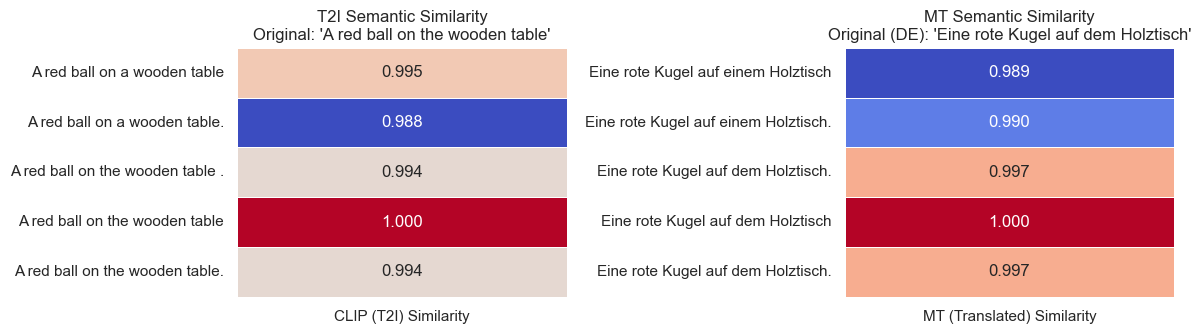

Original (EN): A red ball on the wooden table
Original (DE): Eine rote Kugel auf dem Holztisch

Paraphrase (EN): A red ball on a wooden table
Paraphrase (DE): Eine rote Kugel auf einem Holztisch
  → CLIP (T2I) Similarity: 0.9953
  → MT (Translated) Similarity: 0.9889

Paraphrase (EN): A red ball on a wooden table.
Paraphrase (DE): Eine rote Kugel auf einem Holztisch.
  → CLIP (T2I) Similarity: 0.9882
  → MT (Translated) Similarity: 0.9902

Paraphrase (EN): A red ball on the wooden table .
Paraphrase (DE): Eine rote Kugel auf dem Holztisch.
  → CLIP (T2I) Similarity: 0.9945
  → MT (Translated) Similarity: 0.9967

Paraphrase (EN): A red ball on the wooden table
Paraphrase (DE): Eine rote Kugel auf dem Holztisch
  → CLIP (T2I) Similarity: 1.0000
  → MT (Translated) Similarity: 1.0000

Paraphrase (EN): A red ball on the wooden table.
Paraphrase (DE): Eine rote Kugel auf dem Holztisch.
  → CLIP (T2I) Similarity: 0.9945
  → MT (Translated) Similarity: 0.9967



In [21]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, CLIPTokenizer, CLIPTextModel
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

para_model_name = "Vamsi/T5_Paraphrase_Paws"
para_tok = AutoTokenizer.from_pretrained(para_model_name)
para_model = AutoModelForSeq2SeqLM.from_pretrained(para_model_name)

mt_model_name = "Helsinki-NLP/opus-mt-en-de"
mt_tok = AutoTokenizer.from_pretrained(mt_model_name)
mt_model = AutoModelForSeq2SeqLM.from_pretrained(mt_model_name, output_attentions=True)

clip_tok = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_enc = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

def embed_clip(txt):
    """Erstellt CLIP-Embedding (T2I)"""
    inputs = clip_tok(txt, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        emb = clip_enc(**inputs).last_hidden_state.mean(dim=1)
    return emb

def cosine(a, b):
    return torch.nn.functional.cosine_similarity(a, b).item()

def translate_mt(texts):
    """Übersetzt Texte mit dem MT-Modell (EN→DE)"""
    translated = []
    for t in texts:
        inp = mt_tok(t, return_tensors="pt", truncation=True)
        out = mt_model.generate(**inp, max_length=60)
        translated.append(mt_tok.decode(out[0], skip_special_tokens=True))
    return translated

original = "A red ball on the wooden table"
input_text = f"paraphrase: {original} </s>"
inputs = para_tok([input_text], return_tensors="pt", truncation=True)

outputs = para_model.generate(
    **inputs,
    max_length=60,
    num_beams=5,
    num_return_sequences=5,
    temperature=1.2,
    top_p=1.9,
    do_sample=True
)

paraphrases = list(set([para_tok.decode(g, skip_special_tokens=True) for g in outputs]))

orig_emb = embed_clip(original)
clip_sims = [cosine(orig_emb, embed_clip(p)) for p in paraphrases]

orig_trans = translate_mt([original])[0]
para_trans = translate_mt(paraphrases)

orig_trans_emb = embed_clip(orig_trans)
mt_sims = [cosine(orig_trans_emb, embed_clip(p)) for p in para_trans]

fig, axes = plt.subplots(1, 2, figsize=(12, len(paraphrases) * 0.7))

sns.heatmap(
    np.array(clip_sims).reshape(-1, 1),
    annot=[[f"{s:.3f}"] for s in clip_sims],
    fmt="",
    cmap="coolwarm",
    cbar=False,
    yticklabels=paraphrases,
    xticklabels=["CLIP (T2I) Similarity"],
    ax=axes[0],
    linewidths=0.5
)
axes[0].set_title(f"T2I Semantic Similarity\nOriginal: '{original}'")

sns.heatmap(
    np.array(mt_sims).reshape(-1, 1),
    annot=[[f"{s:.3f}"] for s in mt_sims],
    fmt="",
    cmap="coolwarm",
    cbar=False,
    yticklabels=para_trans,
    xticklabels=["MT (Translated) Similarity"],
    ax=axes[1],
    linewidths=0.5
)
axes[1].set_title(f"MT Semantic Similarity\nOriginal (DE): '{orig_trans}'")

plt.tight_layout()
plt.show()

print(f"Original (EN): {original}")
print(f"Original (DE): {orig_trans}\n")

for p, pt, s1, s2 in zip(paraphrases, para_trans, clip_sims, mt_sims):
    print(f"Paraphrase (EN): {p}")
    print(f"Paraphrase (DE): {pt}")
    print(f"  → CLIP (T2I) Similarity: {s1:.4f}")
    print(f"  → MT (Translated) Similarity: {s2:.4f}\n")


Hohe Cosine Similarity-Werte: CLIP ist darauf trainiert, Bedeutung, nicht Form, zu verstehen. Satzzeichen oder Großschreibung ändern kaum etwas an der Semantik.

top_p ändern.

Andere Modelle:
- tuner007/pegasus_paraphrase (Google Pegasus)
- facebook/bart-large-cnn (BART)
- Helsinki-NLP/opus-mt-en-de

# Negation & Quantifier-Tests

In [22]:
pairs = [
    ("A red ball on the table", "No red ball on the table"),
    ("A red ball on the table", "Three red balls on the table"),
]

clip_tok = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_enc = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

def embed(txt):
    t = clip_tok(txt, return_tensors="pt")
    with torch.no_grad():
        e = clip_enc(**t).last_hidden_state.mean(1)
    return e

for t1, t2 in pairs:
    e1, e2 = embed(t1), embed(t2)
    sim = cosine_similarity(e1, e2)[0][0]
    print(f"{t1} ↔ {t2} → CosineSim={sim:.4f}")


A red ball on the table ↔ No red ball on the table → CosineSim=0.7699
A red ball on the table ↔ Three red balls on the table → CosineSim=0.8533


# Nonsense-Sätze auswerten (Textverständnis & Logik)

Untersuchen, wie robust die Textrepräsentation eines Modells ist:

erkennt es semantischen Unsinn?

oder behandelt es Nonsense ähnlich wie sinnvolle Sätze?

Das ist besonders spannend im Vergleich:

T2I (CLIP) → semantisch / visuell orientiert

MT (Helsinki) → sprachlich / syntaktisch orientiert

In [23]:
sentences = [
    "A red ball on the wooden table",                # sinnvoll
    "A wooden red table on the ball",                # syntaktisch ok, semantisch seltsam
    "The table eats the red ball",                   # logisch falsch
    "Red ball table wooden on the",                  # Wortsalat
    "A quantum banana philosophizes silently",       # semantischer Nonsense
]


In [24]:
def clip_embed(text):
    inputs = clip_tok(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        return clip_enc(**inputs).last_hidden_state.mean(dim=1)

clip_embeddings = torch.cat([clip_embed(s) for s in sentences])

clip_sim_matrix = torch.nn.functional.cosine_similarity(
    clip_embeddings.unsqueeze(1),
    clip_embeddings.unsqueeze(0),
    dim=-1
).cpu().numpy()


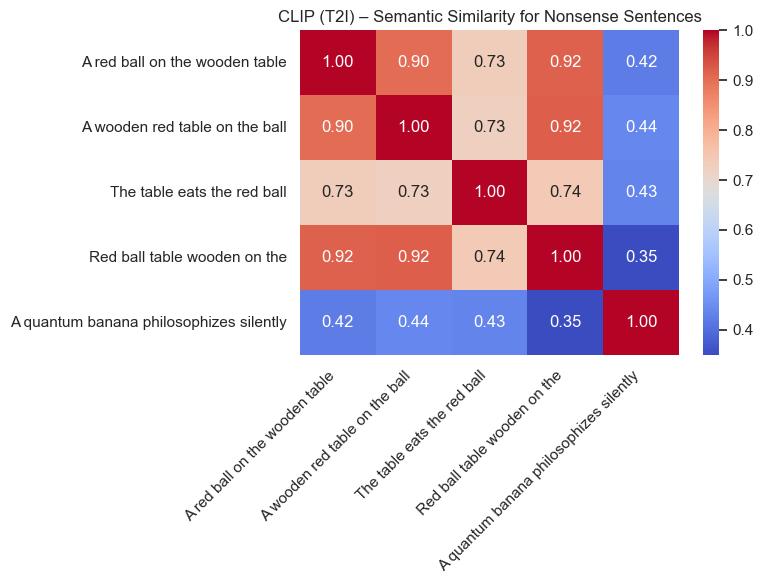

In [25]:
plt.figure(figsize=(8,6))
sns.heatmap(
    clip_sim_matrix,
    xticklabels=sentences,
    yticklabels=sentences,
    cmap="coolwarm",
    annot=True,
    fmt=".2f"
)
plt.title("CLIP (T2I) – Semantic Similarity for Nonsense Sentences")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [26]:
def mt_embed(text):
    inputs = mt_tok(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True
    )

    with torch.no_grad():
        outputs = mt_enc(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            return_dict=True
        )

    return outputs.last_hidden_state.mean(dim=1)


In [27]:
print(type(mt_enc)) 

<class 'transformers.models.marian.modeling_marian.MarianMTModel'>


In [31]:
mt_embeddings = torch.cat(
    [mt_embed(s) for s in sentences],
    dim=0
)

mt_sim_matrix = torch.nn.functional.cosine_similarity(
    mt_embeddings.unsqueeze(1),
    mt_embeddings.unsqueeze(0),
    dim=-1
).cpu().numpy()

print(mt_sim_matrix.shape)


(5, 5)


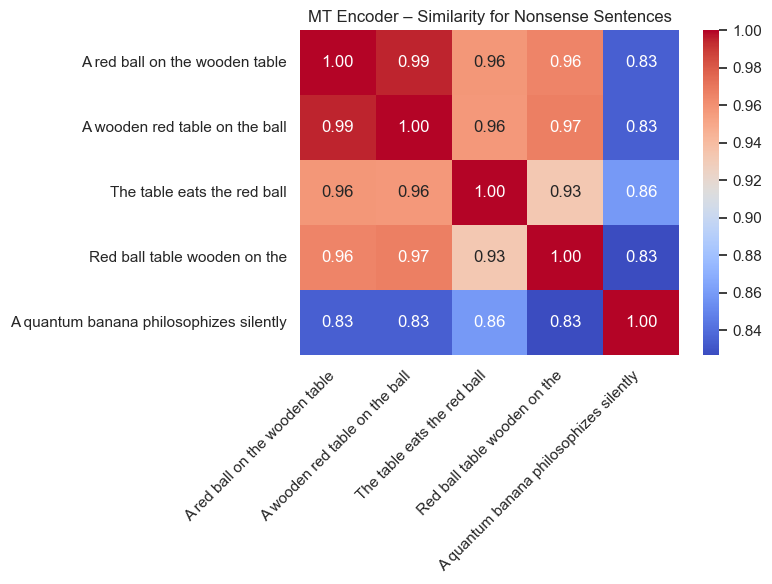

In [32]:
plt.figure(figsize=(8,6))
sns.heatmap(
    mt_sim_matrix,
    xticklabels=sentences,
    yticklabels=sentences,
    cmap="coolwarm",
    annot=True,
    fmt=".2f"
)
plt.title("MT Encoder – Similarity for Nonsense Sentences")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Bilder generieren

In [33]:
from diffusers import StableDiffusionPipeline


In [34]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
)
pipe = pipe.to("cpu")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [35]:
def generate_image(prompt, seed):
    generator = torch.Generator(device=pipe.device).manual_seed(seed)
    image = pipe(
        prompt,
        generator=generator,
        num_inference_steps=30,
        guidance_scale=7.5
    ).images[0]
    return image


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

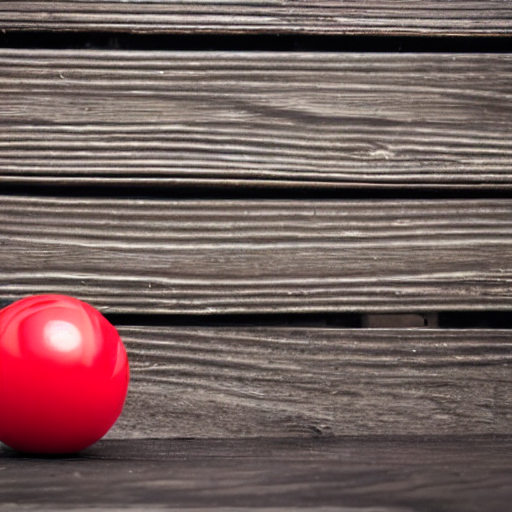

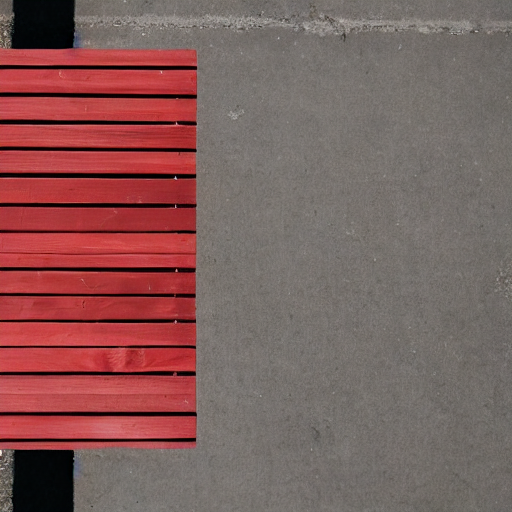

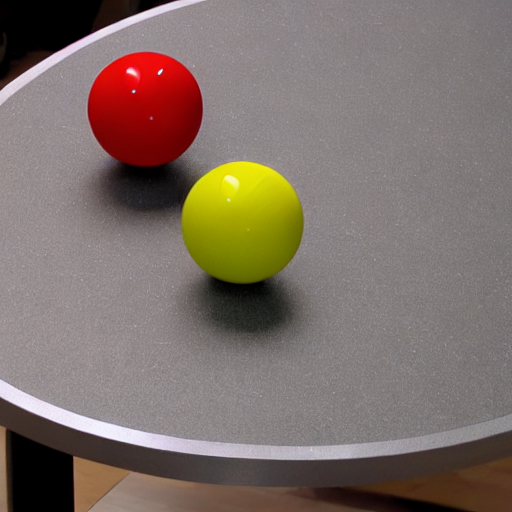

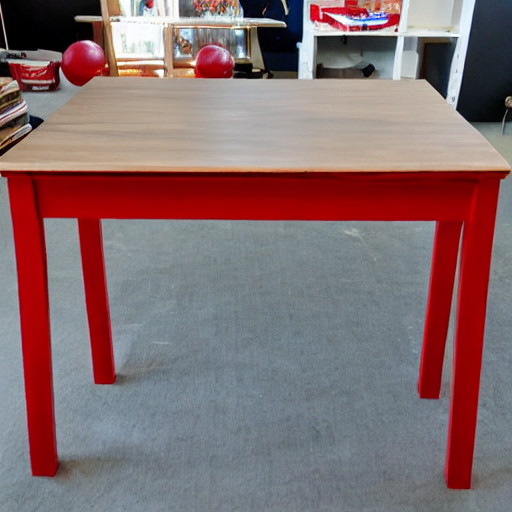

In [36]:
prompt_richtig = "A red ball on the wooden table"
prompt_semantisch_nonsense = "A wooden red table on the ball"
prompt_logisch_nonsense = "The table eats the red ball"
prompt_struktur_nonsense = "Red ball table wooden on the"

img_richtig = generate_image(prompt_richtig, seed=123)
img_semantisch_nonsense = generate_image(prompt_semantisch_nonsense, seed=123)
img_logisch_nonsense = generate_image(prompt_logisch_nonsense, seed=123)
img_struktur_nonsense = generate_image(prompt_struktur_nonsense, seed=123)

display(img_richtig)
display(img_semantisch_nonsense)
display(img_logisch_nonsense)
display(img_struktur_nonsense)